In [1]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torch import nn
import math
import os
from torchmetrics.classification import MulticlassF1Score

### Load data

In [2]:
# load data
data_patch = "/kaggle/input/aiomodule6flower-photos/flower_photos"
dataset = ImageFolder(root=data_patch)
num_samples = len(dataset)
classes = dataset.classes
num_classes = len(dataset.classes)

# split
TRAIN_RATIO, VALID_RATIO = 0.8, 0.1
n_train_examples = int(num_samples * TRAIN_RATIO)
n_val_examples = int(num_samples * VALID_RATIO)
n_test_examples = num_samples - n_train_examples - n_val_examples
train_dataset, val_dataset, test_dataset = random_split(
    dataset, [n_train_examples, n_val_examples, n_test_examples]
)

### Preprocessing

In [3]:
# resize + convert to tensor
IMG_SIZE = 224
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]


train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(0.2),
    # transforms.RandomCrop(IMG_SIZE, padding = 5),
    # transforms.RandomErasing(
    #     p = 0.75,
    #     scale = (0.01, 0.3),
    #     ratio = (1.0, 1.0),
    #     value = 0,
    #     inplace = True
    # ),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

train_dataset.dataset.transform = train_transforms

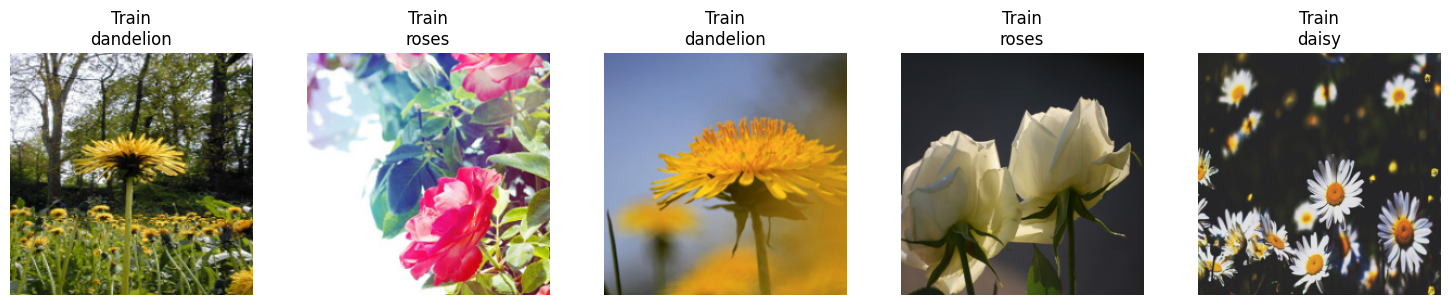

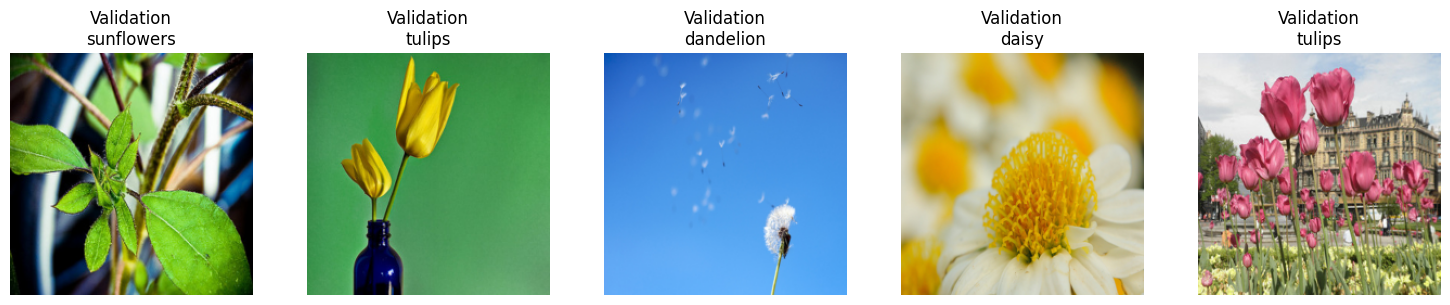

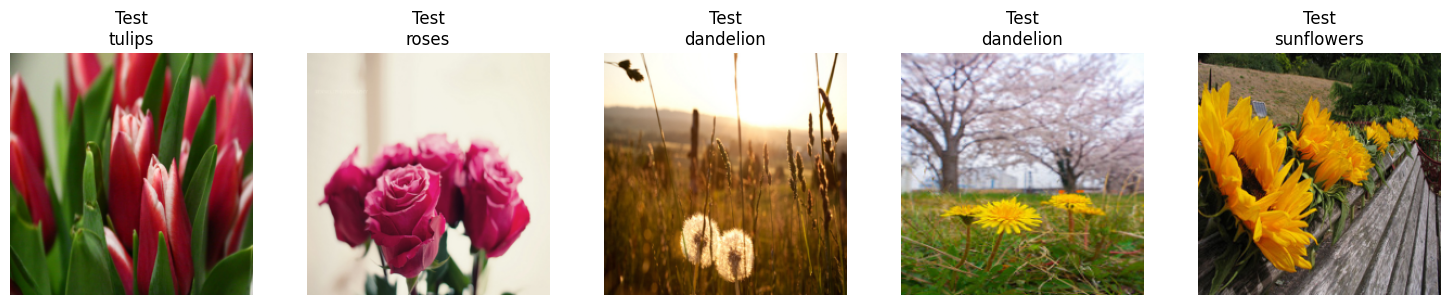

In [4]:
import matplotlib.pyplot as plt
import random

# Helper to denormalize for visualization
def denormalize(img_tensor, mean, std):
    img = img_tensor.clone()
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)
    return img

# Helper to plot images from a dataset
def show_random_images(dataset, dataset_name, mean, std, num_images=5):
    indices = random.sample(range(len(dataset)), num_images)
    class_names = dataset.dataset.classes

    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(indices):
        img, label = dataset[idx]
        img = denormalize(img, mean, std)  # undo normalization
        img = img.permute(1, 2, 0).numpy()  # CxHxW → HxWxC

        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(f"{dataset_name}\n{class_names[label]}")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

# Show images from each dataset
show_random_images(train_dataset, "Train", mean, std)
show_random_images(val_dataset, "Validation", mean, std)
show_random_images(test_dataset, "Test", mean, std)

### Create dataloader

In [6]:
BATCH_SIZE = 512

train_loader = DataLoader(
    train_dataset,
    shuffle=True,
    batch_size=BATCH_SIZE
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE
)

### Create Model

In [7]:
import torch
import torch.nn as nn

class PatchPositionEmbedding(nn.Module):
    def __init__(self, embed_dim, patch_size, img_size):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = embed_dim, kernel_size = patch_size, stride = patch_size, bias = False)

        scale = embed_dim ** -0.5
        self.class_embedding = nn.Parameter(scale * torch.randn(embed_dim))
        self.positional_embedding = nn.Embedding(num_embeddings= (img_size // patch_size) ** 2 + 1, embedding_dim= embed_dim) 
        # return lookup table

    def forward(self, X):
        device = X.device
        
        X = self.conv1(X) # shape: [B, C, W, H]
        X = X.reshape(X.shape[0], X.shape[1], -1) #[B, C, W*H]
        X = X.permute(0, 2, 1) #[B, W*H, C] = [B, L, D]
        # Expand class_embedding
        cls_embs =self.class_embedding.unsqueeze(0).unsqueeze(1).expand(X.shape[0], 1, -1)
        X = torch.cat([cls_embs, X], dim = 1) # [B, L + 1, D]
        pos_l = torch.arange(X.shape[1]).to(device)
        pos_embed = self.positional_embedding(pos_l)
        X = X + pos_embed

        return X

In [8]:
class transformer_layer(nn.Module):
    def __init__(self, d_model, num_heads, ff_dim):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim = d_model, 
                                          num_heads = num_heads,
                                         batch_first = True)
        self.ffn = nn.Sequential (
                nn.Linear( in_features = embed_dim , out_features = ff_dim , bias = True ) ,
                nn.LeakyReLU(0.1) ,
                nn.Linear( in_features = ff_dim , out_features = embed_dim , bias = True )
        )
        self.layer_norm_1 = nn.LayerNorm(d_model)
        self.layer_norm_2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(0.5)

    def forward(self, Q, K, V):
        attn_output , _ = self.attn(Q, K, V)
        attn_output = self.dropout(attn_output)
        out_1 = self.layer_norm_1(Q + attn_output)
        ffn_output = self.ffn(out_1)
        ffn_output = self.dropout(ffn_output)
        out_2 = self.layer_norm_2(out_1 + ffn_output)
        return out_2

In [9]:
class VisionTransformerCls(nn.Module):
    def __init__(self, image_size, embed_dim, num_heads, ff_dim, 
                dropout =0.1, num_classes = 10, patch_size = 16):
        super().__init__()
        self.embed_layer = PatchPositionEmbedding(
            img_size =image_size, embed_dim = embed_dim, patch_size = patch_size
        )
        self.transformer_layer = transformer_layer(
            embed_dim, num_heads, ff_dim
        )
    
        self.classifier = nn.Sequential(
            nn.Linear(in_features = embed_dim, out_features = 20),
            nn.LeakyReLU(0.1),
            nn.Dropout(p = dropout),
            nn.Linear(in_features = 20, out_features = num_classes),
        )

    def forward(self, X):
        output = self.embed_layer(X)
        output = self.transformer_layer(output, output, output)
        output = output[:, 0, :] # get only first L
        output = self.classifier(output)
        return output

In [10]:
num_classes = len(next(iter(train_loader))[1].unique())
image_size = IMG_SIZE
embed_dim = 512
num_heads = 8
ff_dim = 1024
model = VisionTransformerCls(image_size, embed_dim, num_heads, ff_dim, 
                dropout =0.1, num_classes = num_classes, patch_size = 16)
model

VisionTransformerCls(
  (embed_layer): PatchPositionEmbedding(
    (conv1): Conv2d(3, 512, kernel_size=(16, 16), stride=(16, 16), bias=False)
    (positional_embedding): Embedding(197, 512)
  )
  (transformer_layer): transformer_layer(
    (attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
    )
    (ffn): Sequential(
      (0): Linear(in_features=512, out_features=1024, bias=True)
      (1): LeakyReLU(negative_slope=0.1)
      (2): Linear(in_features=1024, out_features=512, bias=True)
    )
    (layer_norm_1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (layer_norm_2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=512, out_features=20, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=20, out_features=5, bias=True)
  )
)

In [11]:
from torchinfo import summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

summary(model.to(device), input_size=(1, 3, 224, 224))  

Layer (type:depth-idx)                   Output Shape              Param #
VisionTransformerCls                     [1, 5]                    --
├─PatchPositionEmbedding: 1-1            [1, 197, 512]             512
│    └─Conv2d: 2-1                       [1, 512, 14, 14]          393,216
│    └─Embedding: 2-2                    [197, 512]                100,864
├─transformer_layer: 1-2                 [1, 197, 512]             --
│    └─MultiheadAttention: 2-3           [1, 197, 512]             1,050,624
│    └─Dropout: 2-4                      [1, 197, 512]             --
│    └─LayerNorm: 2-5                    [1, 197, 512]             1,024
│    └─Sequential: 2-6                   [1, 197, 512]             --
│    │    └─Linear: 3-1                  [1, 197, 1024]            525,312
│    │    └─LeakyReLU: 3-2               [1, 197, 1024]            --
│    │    └─Linear: 3-3                  [1, 197, 512]             524,800
│    └─Dropout: 2-7                      [1, 197, 512]

### Training Session

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [13]:
def evaluate(model, test_dataloader, criterion, metric, device):
    model.eval()
    losses = []

    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())

            _, predicted = torch.max(outputs, 1)
            metric.update(predicted, labels)

    loss = sum(losses) / len(losses)
    metric_score = metric.compute().item()

    return loss, metric_score

In [14]:
def fit(
    model,
    train_loader,
    val_loader,
    criterion,
    metric,
    optimizer,
    device,
    epochs
):
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    best_model_state = None
    best_score = 0

    model.to(device)
    for epoch in range(epochs):
        batch_train_losses = []
        model.train()
        metric.reset()    
        
        for idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())
            
            _, predicted = torch.max(outputs, 1)
            metric.update(predicted, labels)

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        train_acc = metric.compute().item()
        train_accs.append(train_acc)


        val_loss, val_acc = evaluate(
            model, val_loader, criterion, metric, device
        )
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(
            f"""
            EPOCH {epoch + 1}:\n
            \tTrain loss: {train_loss:.4f}\tTrain Acc: {train_acc:.4f}\n
            \tVal loss: {val_loss:.4f}\tVal Acc: {val_acc:.4f}
            """)

        if val_acc > best_score:
            best_score = val_acc
            best_model_state = model.state_dict()
            print("=====================")
            print(f"Epoch {epoch+1}: New best F1 on val = {best_score}, saving model...") 
            print("=====================")
        
    return train_losses, train_accs, val_losses, val_accs, best_model_state

In [15]:
num_classes = len(train_dataset.dataset.classes)
image_size = IMG_SIZE
embed_dim = 512
num_heads = 8
ff_dim = 1024
model = VisionTransformerCls(image_size, embed_dim, num_heads, ff_dim, 
                dropout =0.1, num_classes = num_classes, patch_size = 16)

epochs = 50
#, weight_decay=1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
criterion = nn.CrossEntropyLoss()
metric = MulticlassF1Score(num_classes=num_classes, average='macro').to(device)

In [16]:
results = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    metric,
    optimizer,
    device,
    epochs
)


            EPOCH 1:

            	Train loss: 1.6519	Train Acc: 0.1927

            	Val loss: 1.5069	Val Acc: 0.2087
            
Epoch 1: New best F1 on val = 0.20865121483802795, saving model...

            EPOCH 2:

            	Train loss: 1.6084	Train Acc: 0.2455

            	Val loss: 1.4814	Val Acc: 0.2467
            
Epoch 2: New best F1 on val = 0.24673257768154144, saving model...

            EPOCH 3:

            	Train loss: 1.4262	Train Acc: 0.3377

            	Val loss: 1.3647	Val Acc: 0.3411
            
Epoch 3: New best F1 on val = 0.34112995862960815, saving model...

            EPOCH 4:

            	Train loss: 1.2719	Train Acc: 0.3726

            	Val loss: 1.3280	Val Acc: 0.3733
            
Epoch 4: New best F1 on val = 0.37325674295425415, saving model...

            EPOCH 5:

            	Train loss: 1.2480	Train Acc: 0.3993

            	Val loss: 1.3473	Val Acc: 0.3974
            
Epoch 5: New best F1 on val = 0.39735347032546997, saving model...


In [17]:
# epochs = 50
# optimizer = torch.optim.Adam(model.parameters(), lr=0.003, weight_decay=1e-4)
# criterion = nn.CrossEntropyLoss()

In [18]:
# from sklearn.metrics import f1_score
# best_f1_val = 0.0
# best_model_state = None

# train_lossess = []
# val_lossess = []
# f1_train = []
# f1_val = []

# for epoch in range(epochs):
#     train_loss = 0
#     val_loss = 0

#     y_train_label_pred = []
#     y_train_label_true = []

#     y_val_label_pred = []
#     y_val_label_true = []

#     # Training session
#     model.train()
#     for X_train, y_train in train_loader:
#         X_train = X_train.to(device)
#         y_train = y_train.to(device)
#         optimizer.zero_grad()  # Reset gradients

#         # Forward pass
#         y_pred = model(X_train)

#         # Compute loss
#         loss = criterion(y_pred.squeeze(), y_train)
#         train_loss += loss.item()

#         # Predictions
#         y_train_label_true.extend(y_train.tolist())
#         y_train_label_pred.extend(torch.argmax(y_pred, dim = 1).tolist())

#         # Backpropagation
#         loss.backward()
#         optimizer.step()

#     train_loss /= len(train_loader)
#     train_lossess.append(train_loss)

#     f1_score_train = f1_score(y_train_label_true, y_train_label_pred, average='macro')
#     f1_train.append(f1_score_train)

#     # Validation session
#     model.eval()
#     with torch.no_grad():
#         for X_val, y_val in val_loader:
#             X_val = X_val.to(device)
#             y_val = y_val.to(device)
#             y_pred = model(X_val)
#             loss = criterion(y_pred.squeeze(), y_val)
#             val_loss += loss.item()

#             y_val_label_true.extend(y_val.tolist())
#             y_val_label_pred.extend(torch.argmax(y_pred, dim=1).tolist())

#         val_loss /= len(val_loader)
#         val_lossess.append(val_loss)

#         f1_score_val = f1_score(y_val_label_true, y_val_label_pred, average='macro')
#         f1_val.append(f1_score_val)

#         # Save best model based on validation F1 score
#         if f1_score_val > best_f1_val:
#             best_f1_val = f1_score_val
#             best_model_state = model.state_dict()
#             print(f"Epoch {epoch+1}: New best F1 on val = {f1_score_val:.4f}, saving model...")

# # # After training, save the best model weights to a file
# # torch.save(best_model_state, 'best_model.pth')
# # print("Training complete. Best model saved as 'best_model.pth'")

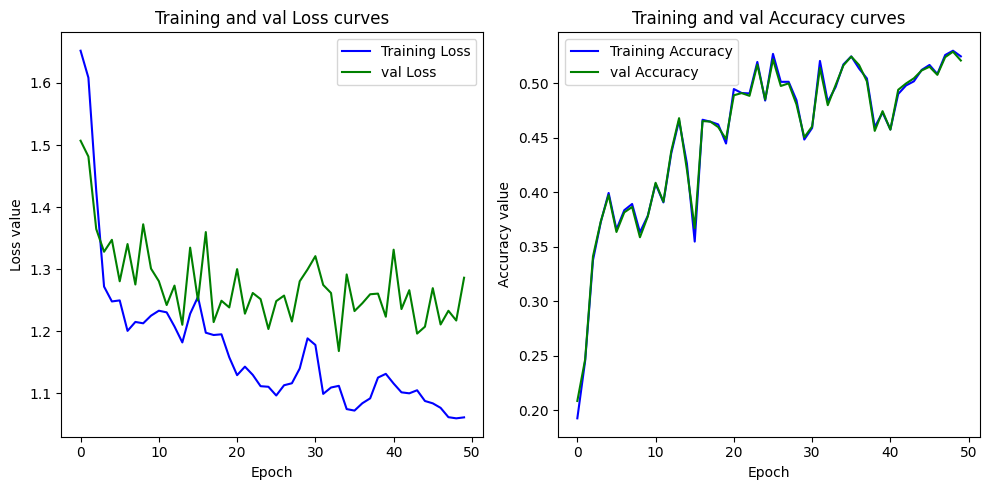

In [19]:
def plot_results(Training_Loss, Training_Acc, val_Loss, val_Acc):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(Training_Loss, color="blue", label="Training Loss")
    plt.plot(val_Loss, color="green", label="val Loss")
    plt.title("Training and val Loss curves")
    plt.xlabel("Epoch")
    plt.ylabel("Loss value")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(Training_Acc, color="blue", label="Training Accuracy")
    plt.plot(val_Acc, color="green", label="val Accuracy")
    plt.title("Training and val Accuracy curves")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy value")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_results(results[0], results[1], results[2], results[3])

### Testing Session

In [20]:
model.load_state_dict(results[4])
model.to(device)

test_loss, test_acc = evaluate(
    model, test_loader, criterion, metric, device
)

print(test_loss, test_acc)

1.1471171379089355 0.5184360146522522


In [21]:
# y_test_label_true = []
# y_test_label_pred = []

# model.eval()
# with torch.no_grad():
#     for X_test, y_test in test_loader:
#         X_test = X_test.to(device)
#         y_test = y_test.to(device)
#         y_pred = model(X_test)
#         loss = criterion(y_pred.squeeze(), y_test)
#         val_loss += loss.item()

#         y_test_label_true.extend(y_test.tolist())
#         y_test_label_pred.extend(torch.argmax(y_pred, dim=1).tolist())

#     val_loss /= len(test_loader)
#     f1_score_test = f1_score(y_test_label_true, y_test_label_pred, average = 'macro')

# f1_score_test